In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as stats
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
%matplotlib inline

In [2]:
data = pd.read_csv('data/Flight-Overbooking-Data.csv')

In [3]:
# Convert Date column to datetime. The rest of the data is clean
data["Date"] = pd.to_datetime(data["Date"])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
Date      730 non-null datetime64[ns]
Demand    730 non-null int64
Booked    730 non-null int64
Shows     730 non-null int64
Rate      730 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 28.6 KB


In [81]:
lam = int(data.Demand.mean())

In [82]:
var_check = int(data.Demand.var())

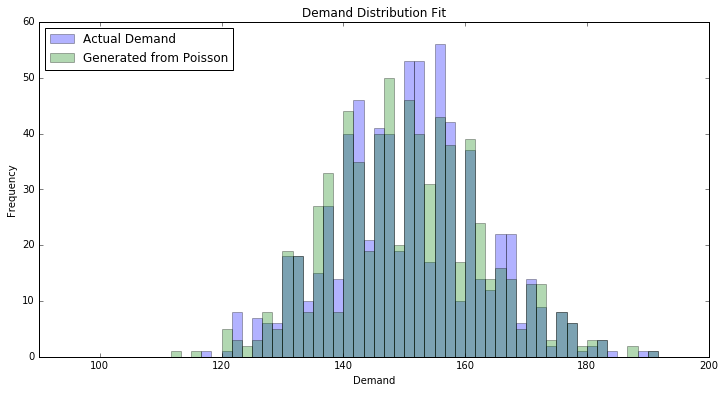

In [131]:
# Plot histogram of the demand data with generated sample Poisson data histogram to see how Poisson distribution fits
plt.figure(figsize=(12,6))
bins = np.linspace(80, 200, 73)
actual_demand = data["Demand"].values
poisson = np.random.poisson(lam = lam, size = 730)
plt.hist(actual_demand, bins, alpha = 0.3, label="Actual Demand")
plt.hist(poisson, bins, alpha = 0.3, label = "Generated from Poisson")
plt.xlim(90,200)
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.legend(loc='upper left')
plt.title("Demand Distribution Fit")
# plt.savefig("plots/distribution_fit_plot.png")
plt.show()

In [168]:
# Checking Poisson dist fit to actual demand data
cos_sim(actual_demand, poisson)

/Users/asalmitrofanov/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/asalmitrofanov/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.99363836]])

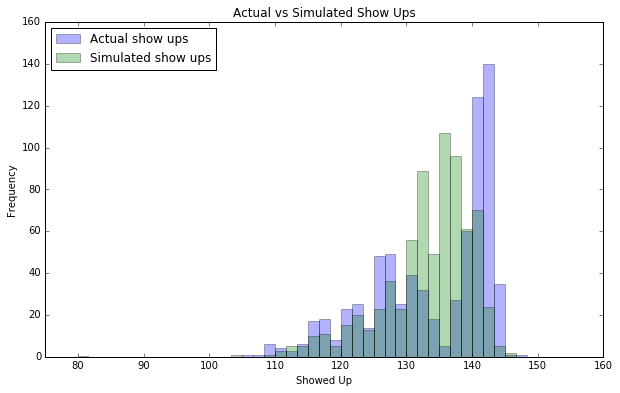

In [176]:
actual_show_ups = data.Shows.values
actual_p = data.Rate.values.mean()
actual_booked = data.Booked.values

# Setting overbooking limit
overbooking_lim = 15

# Limiting number of tickets booked to overbooking limit. 
# Using minimum of actual demand and number of seats + overbooking limit for n to simulate show ups with binomial dist
binomial_show_ups = np.array([np.random.binomial(n = min(x,(134+overbooking_lim)), p = actual_p) for x in actual_booked])

plt.figure(figsize=(10, 6))
plt.hist(actual_show_ups, bins, label = "Actual show ups", alpha = 0.3)
plt.hist(binomial_show_ups, bins, label = "Simulated show ups", alpha = 0.3)
plt.xlim(75, 160)
plt.ylim(0, 160)
plt.title("Actual vs Simulated Show Ups")
plt.xlabel("Showed Up")
plt.ylabel("Frequency")
plt.legend(loc="upper left")
plt.savefig("plots/actual_vs_simulated_show_ups.png")
plt.show()

In [177]:
# Checking binomial dist fit to actual show ups
cos_sim(actual_show_ups, binomial_show_ups)

/Users/asalmitrofanov/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/asalmitrofanov/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.99922819]])

In [184]:
def demand_simulation(lam, trials):
    """
    INPUT: lam = average historic demand, INT 
           trials = number of trials to run simulation, INT
           
    OUTPUT: sim_demand = simulated demand, NDARRAY, length = trials
    """
    sim_demand = np.random.poisson(lam=lam, size = trials)
    return sim_demand

In [187]:
demand_sim = demand_simulation(150, 1000)

In [185]:
def booking_capacity(seats, obl):
    """
    INPUT: seats = number of seats in the plane, INT
           obl = overbooking limit, INT
           
    OUTPUT: bc = booking capacity, INT
    """
    bc = seats + obl
    return bc

In [188]:
booking_cap = booking_capacity(134, 15)

In [186]:
def booked_tickets(sim_demand, booking_capacity):
    """
    INPUT: sim_demand = simulated demand, NDARRAY
           booking_capacity  = max number of tickets for sale, INT
    """
    booked = np.array([min(x, booking_capacity) for x in sim_demand])
    return booked

In [189]:
booked_tix = booked_tickets(demand_sim, booking_cap)

In [191]:
def ready_to_board_sim(booked, p):
    """
    INPUT: booked = number of tickets booked, NDARRAY
           p = probability of show-up, FLOAT
           
    OUTPUT: show_ups = simulated number of passengers ready to board, NDARRAY, length = len(booked)
    """
    show_ups = np.array([np.random.binomial(n=x, p=p) for x in booked])
    return show_ups

In [192]:
showed_up = ready_to_board_sim(booked_tix, 0.92)

In [194]:
def no_shows(booked, ready_to_board):
    """
    INPUT: booked = number of tickets booked, NDARRAY
           ready_to_board = number of passengers ready to board, NDARRAY
    OUTPUT: no_shows = number of people missing the flight, NDARRAY 
    """
    no_shows = booked - ready_to_board
    return no_shows

In [195]:
no_shows_test = no_shows(booked_tix, showed_up)

In [201]:
def bumped(seats, ready_to_board):
    """
    INPUT: seats = number of seats in the plane, INT
           ready_to_board = number of passengers ready to board, NDARRAY
    OUTPUT: num_bumped = number of passengers bumped to later flight, NDARRAY
    """
    num_bumped = np.array([max(0, (x-seats)) for x in ready_to_board])
    return num_bumped

In [202]:
bumped_sim = bumped(134, showed_up)

In [205]:
showed_up[:5]

array([135, 139, 139, 138, 135])

In [206]:
bumped_sim[:5]

array([1, 5, 5, 4, 1])

In [ ]:
def simulate_revenue(obl, seats, ticket_price, rebook_fee, trials = 500, lam, p):
    """
    INPUT: obl = overbooking limit, INT
           seats = number of seats in the plane, INT
           ticket_price = price per ticket sold, FLOAT
           rebook_fee = fee to rebook no-show ticke, FLOAT
           trials = number of trials to run simulation, INT
           lam = average historic demand to simulate demand from Poisson distribution, INT
           p = historic show-up rate
    
    OUTPUT: demand = simulated demand, INT
            booking_capacity = maximum allowed number of tickets to be sold for same flight, INT  
            booked = number of tickets sold, INT
            ready_to_board = simulated number of passengers ready to board, INT
            no_shows = number of no-shows, INT
            bumped = number of passengers bumped to later flight, INT
    """
    sim_demand_dist = demand_simulation(lam, trials)
    booking_cap = booking_capacity(seats, obl)
    booked_dist = booked_tickets(sim_demand, booking_cap)
    ready_to_board_dist = ready_to_board_sim(booked, p)
    no_shows_dist = no_shows(booked_dist, ready_to_board_dist)
    bumped_dist = 
    return demand, booking_capacity, booked, ready_to_board, no_shows, bumped, tix_revenue, no_show_revenue, overbooking_cost